# Sedov Blast: Bouchut5

This notebook describes the "Sedov" blast setup computed with the [FLASH 4.3](http://www.flash.uchicago.edu/site/flashcode).

Setup characteristics:

| term                 | symbol    | value               |
|:-------------------- |:---------:|:-------------------:|
| governing equations  |  --       | compressible Euler  |
| equation of state    |  --       |ideal gas (adiabatic)|
| ambient density      | $\rho_0$  | $1.0$               |
| ambient pressure     | $p_0$     | $10^{-5} \approx 0$ |
| adiabatic const.     | $\gamma$  | $1.4$               |
| initial blast energy | $E_0$     | $1.19025916404$     |
| CFD method           |   --      | Finite-Volume       |
| Riemann Flux         |   --      | Bouchut 5           |
| "FV-equiv." resolution | $N_r$   | 768 x 768           |

# Density and pressure heat maps

In [1]:
import sys
import os
home = os.environ['HOME']
sys.path.append(home + '/projects/turbubox/tools/lib')
sys.path.append(home + '/projects/turbubox/tools')

import numpy as np
import pandas as pd
import glob
import turbubox.cubicle as cubicle

import matplotlib
matplotlib.rcParams.update({'font.size': 9})

import matplotlib.pyplot as plt
%matplotlib inline

gamma = 1.4

In [2]:
def mkplot(fh, solver):    
    
    if fh.framework == 'couchdg':
        if hasattr(fh, 'gamma'): gamma = fh.gamma
        
        dens = fh.stitch(0,Nvisu=10)
        momx = fh.stitch(1,Nvisu=10)
        momy = fh.stitch(2,Nvisu=10)
        ener = fh.stitch(3,Nvisu=10)
        
        velx = momx/dens
        vely = momy/dens
        ekin = 0.5*(momx**2+momy**2)/dens
        pres = (gamma-1)*(ener - ekin)
        
        extent = fh.domain.T.ravel()
        
    elif fh.framework == 'flash':
        dens,velx,vely,velz,pres = [x[:,:,0].T for x in fh.get_prims()]
        extent = fh.domain.T.ravel()[0:4]
        
    else:
        raise TypeError('Unknow framework: {}'.format(framework))
    
    mach = np.sqrt(velx**2+vely**2)/np.sqrt(fh.gamma*pres/dens)
    
    dpi = 100
    fig = plt.figure(1,figsize=(2*640/dpi, 480/dpi), dpi=dpi)

    plt.xlim(fh.domain.T[0,:])
    plt.ylim(fh.domain.T[1,:])

    plt.subplot(121)

    plt.suptitle('KHI with {} at time t = {:6.3f}'.format(solver,fh.time))
    
    plt.title('density')
    plt.imshow(
        dens,
        extent = extent,
        vmin = 0.0,
        vmax = 1.2,
        origin='lower',
        interpolation = None,
        cmap = plt.get_cmap('cubehelix'),
    )
    plt.colorbar()

    plt.subplot(122)
    plt.title('mach number')

    plt.imshow(
        mach,
        extent = extent,
        vmin = 0.0,
        vmax = 0.8,
        origin='lower',
        interpolation = None,
        cmap = plt.get_cmap('cubehelix'),
    )
    plt.colorbar()

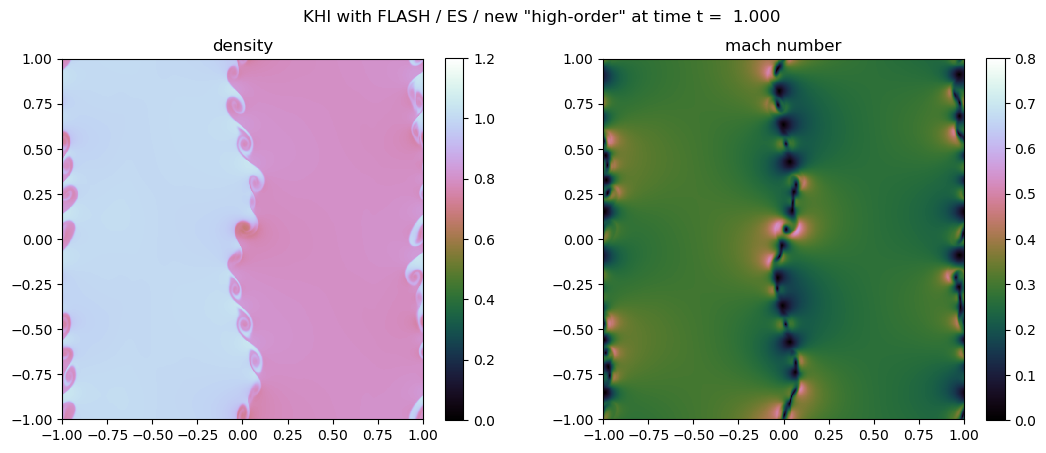

In [15]:
fp = '/home/jmark/Downloads/sim_hdf5_chk_0020_new'
#fp_ = sorted(glob.glob(fp))[-1]
#fp_ = fp
fh = cubicle.File(fp)
#print(dir(fh))
mkplot(fh, solver='FLASH / ES / new "high-order"')

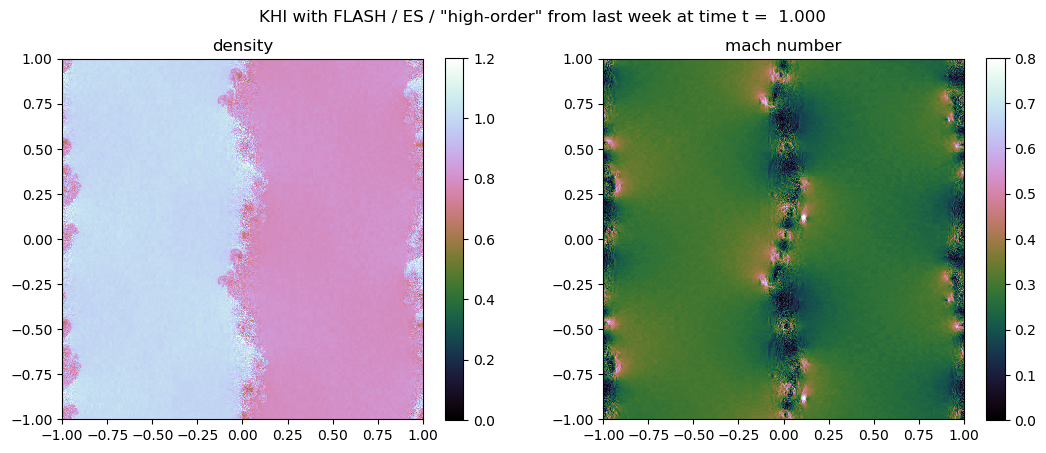

In [16]:
fp = '/home/jmark/Downloads/sim_hdf5_chk_0020'
#fp_ = sorted(glob.glob(fp))[-1]
#fp_ = fp
fh = cubicle.File(fp)
#print(dir(fh))
mkplot(fh, solver='FLASH / ES / "high-order" from last week')

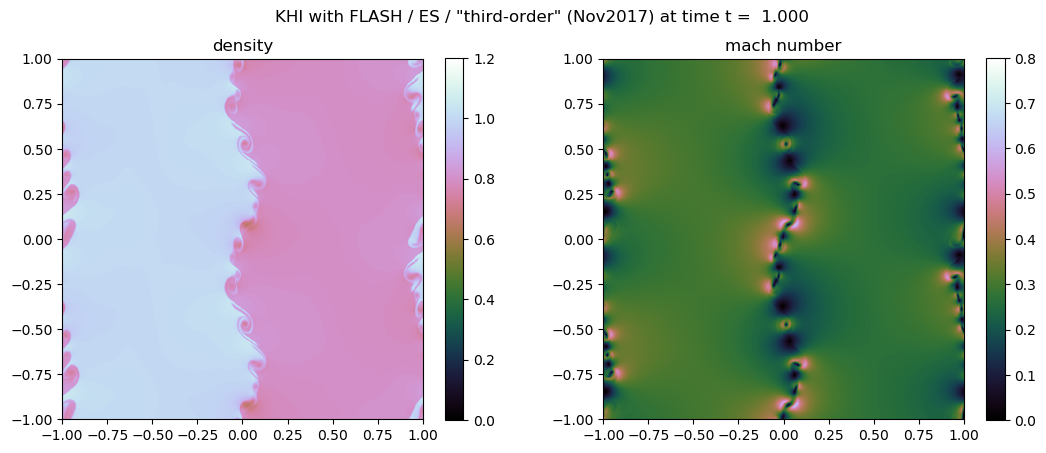

In [17]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/KHI/ES/chkpt/sim_hdf5_chk_0020'
#fp_ = sorted(glob.glob(fp))[-1]
#fp_ = fp
fh = cubicle.File(fp)
mkplot(fh, solver='FLASH / ES / "third-order" (Nov2017)')

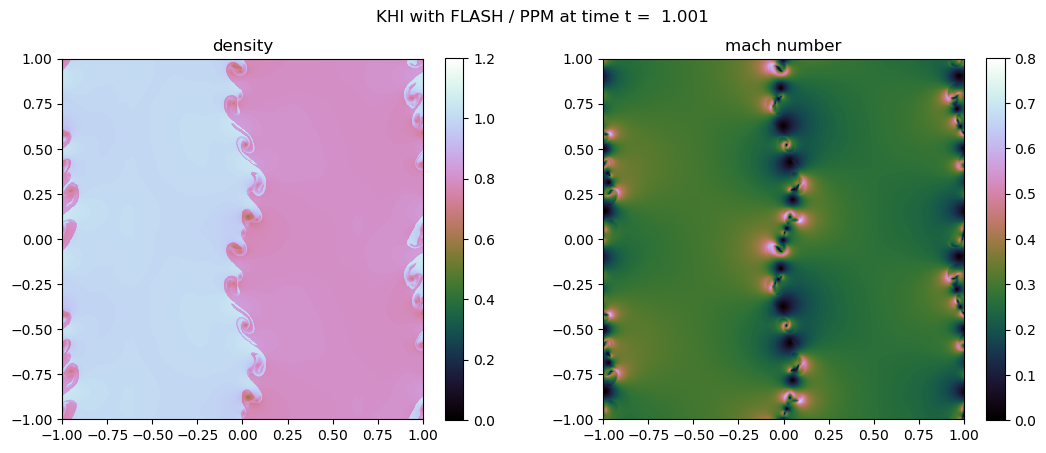

In [18]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/KHI/PPM/chkpt/sim_hdf5_chk_0020'
#fp = '/mnt/sshfs/cheops/scratch/jmarker2/couchdg/KHI/spl-chandrashekar/data/chkpt_0186.h5'
#fp_ = sorted(glob.glob(fp))[-1]
fp_ = fp
fh = cubicle.File(fp_)
mkplot(fh, solver='FLASH / PPM')

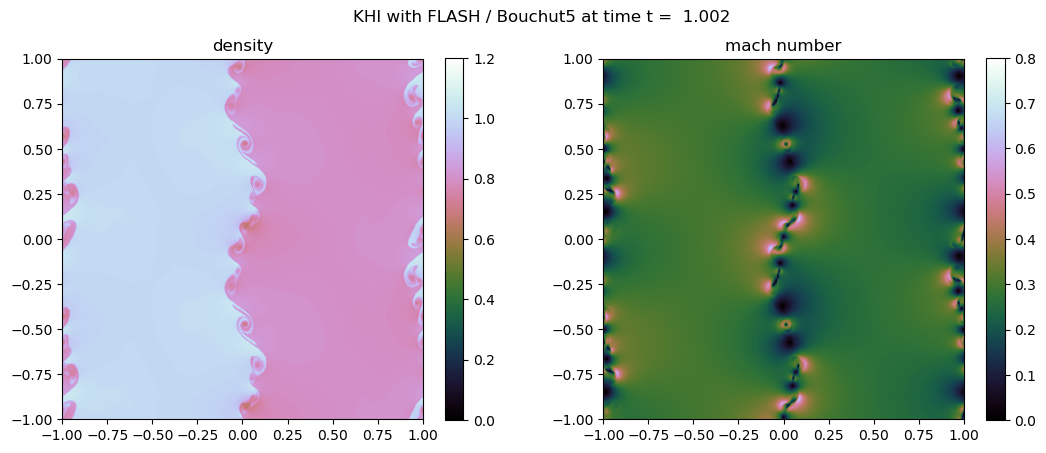

In [22]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/KHI/B5/chkpt/sim_hdf5_chk_0020'
#fp_ = sorted(glob.glob(fp))[-1]
#fp_ = fp
fh = cubicle.File(fp)
mkplot(fh, solver='FLASH / Bouchut5')

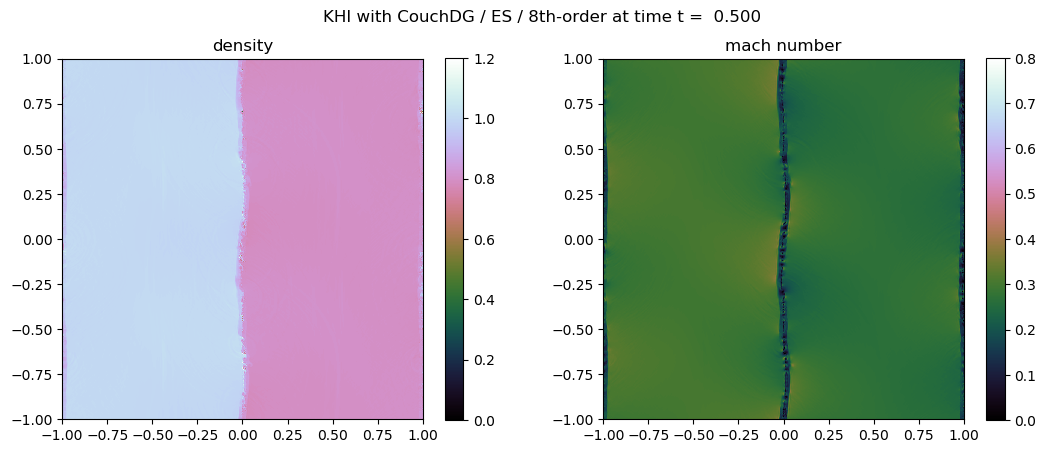

In [5]:
fp = sorted(glob.glob('/mnt/sshfs/cheops/scratch/jmarker2/couchdg/stirturb/div-rusanov/data/chkpt_*.h5'))[-1]
fp = '/mnt/data/couchdg/test/data/chkpt_0050.h5'
fp = '/mnt/sshfs/cheops/scratch/jmarker2/couchdg/KHI/div-ES-Np-7/data/chkpt_0010.h5'
fh = cubicle.File(fp)
mkplot(fh, solver='CouchDG / ES / 8th-order')

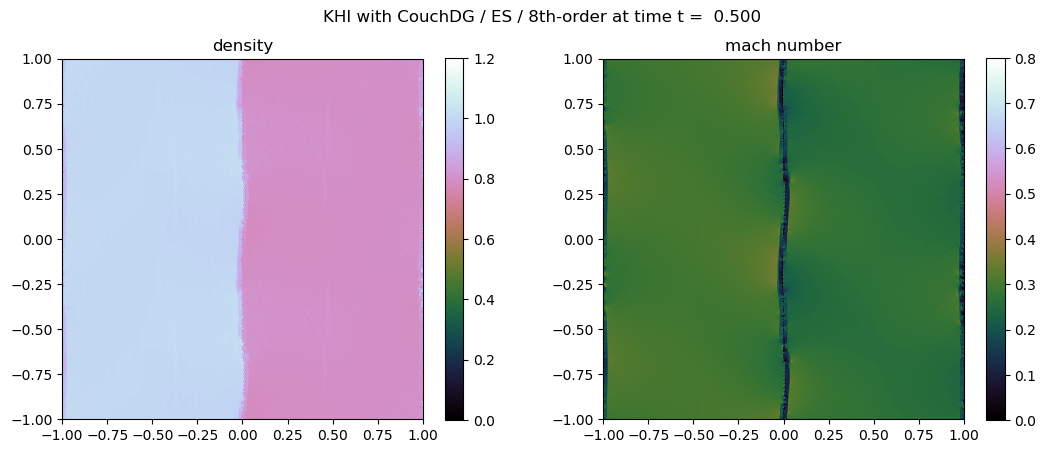

In [3]:
fp = sorted(glob.glob('/mnt/sshfs/cheops/scratch/jmarker2/couchdg/stirturb/div-rusanov/data/chkpt_*.h5'))[-1]
fp = '/mnt/data/couchdg/test/data/chkpt_0050.h5'
fp = '/mnt/sshfs/cheops/scratch/jmarker2/couchdg/KHI/div-ES-SSP-Np-7/data/chkpt_0010.h5'
fh = cubicle.File(fp)
mkplot(fh, solver='CouchDG / ES / 8th-order')

(768, 768)


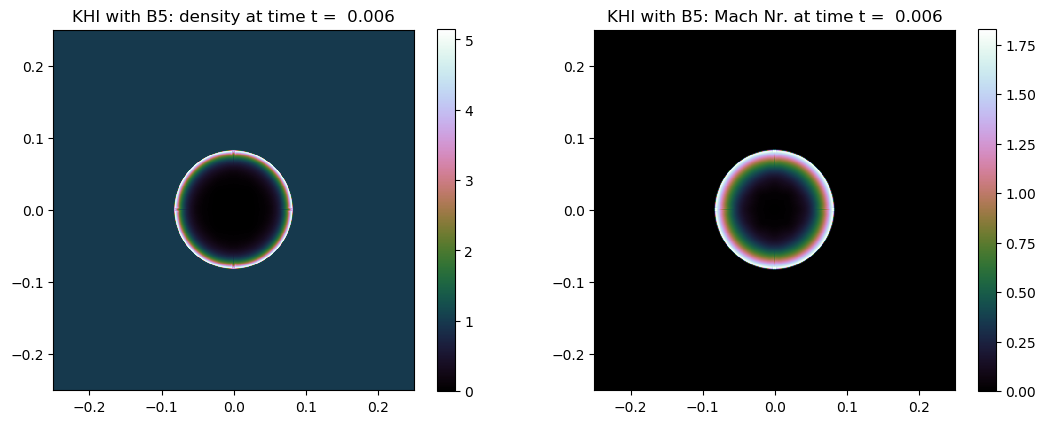

In [90]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/B5/sedov_hdf5_chk_0006'
fh = cubicle.File(fp)
mkplot(fh)

## Shell-averaged density and pressure profiles

In [8]:
mkpd_a = lambda fp: pd.read_table(fp, names='nr radius dens ener pres vels sndspd'.split(), sep='\s+')
dirp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/shell-averages/analytic'
analytics = [mkpd_a(fp) for fp in glob.glob(dirp+'/analytical_*.dat')]

In [9]:
mkpd_d = lambda fp: pd.read_table(fp, names='radius dens'.split(), sep='\s+', skiprows=1)
mkpd_p = lambda fp: pd.read_table(fp, names='radius pres'.split(), sep='\s+', skiprows=1)

dirp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/shell-averages/numeric'
dens = [mkpd_d(fp) for fp in glob.glob(dirp+'/density-*.dat')]
pres = [mkpd_p(fp) for fp in glob.glob(dirp+'/pressure-*.dat')]

numerics = [pd.concat((de,pr.pres),axis=1) for de,pr in zip(dens,pres)]

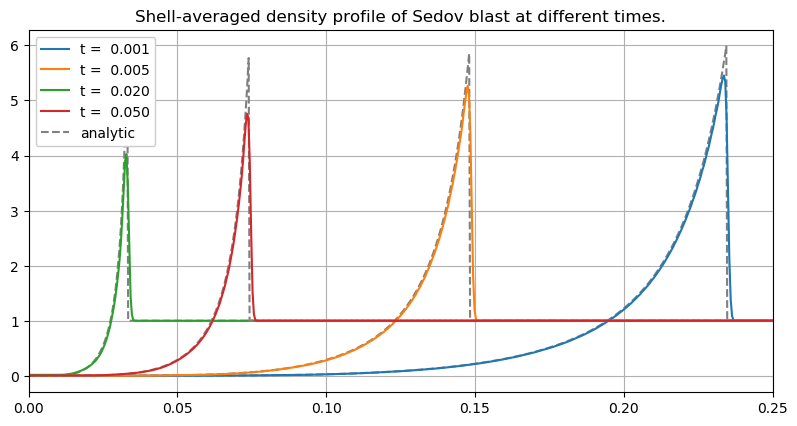

In [13]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.25)
plt.title('Shell-averaged density profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.dens, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.dens, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)

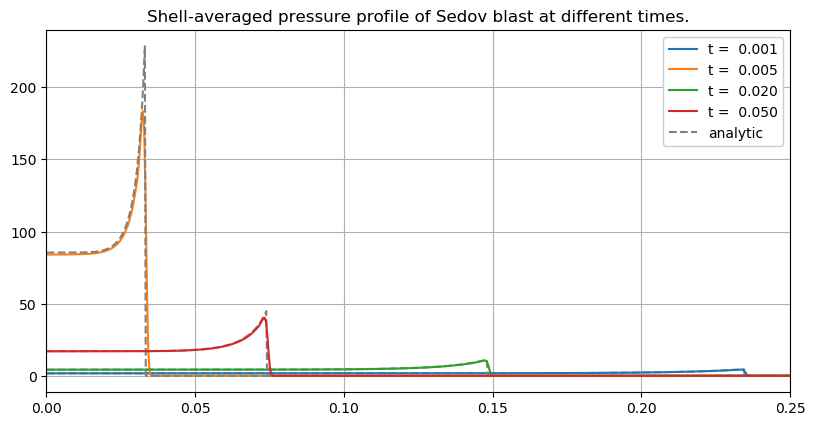

In [11]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.25)
plt.title('Shell-averaged pressure profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.pres, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.pres, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)

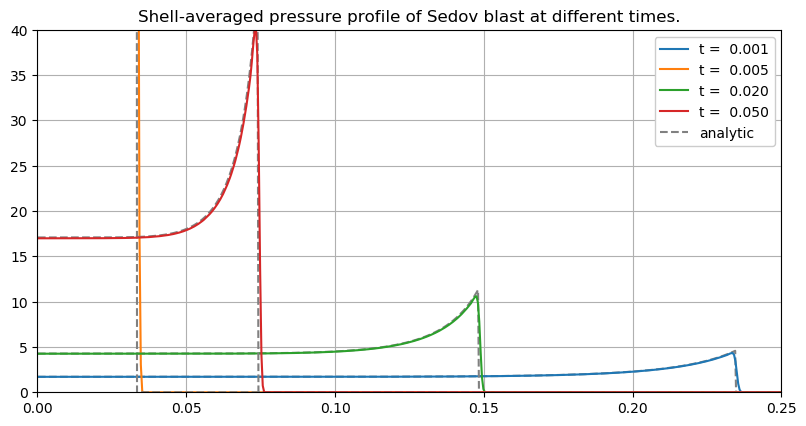

In [12]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.25)
plt.ylim(0,40)
plt.title('Shell-averaged pressure profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.pres, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.pres, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)